In [ ]:
!nvidia-smi

In [73]:
import os
import numpy as np
import vggish_params
import vggish_keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import Accuracy, Precision, Recall
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from statistics import mode
from tqdm import tqdm, trange
import time

In [82]:
sfreq = 1000
sec = 2

In [83]:
X_train = np.load('temporal_data/{}sec/features_train_{}.npy'.format(sec, sfreq), allow_pickle=True)
y_train = np.load('temporal_data/{}sec/labels_train_{}.npy'.format(sec, sfreq), allow_pickle=True)

speech_index = 23

X_train = list(X_train)
y_train = list(y_train)
del X_train[speech_index], y_train[speech_index]

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)    

valid_idx = []
for i in range(len(X_train)):
    if len(X_train[i] == 3):
        valid_idx.append(i)
    elif len(X_train[i] != 0):
        print('ghotala! @ {}'.format(i))

X_train = X_train[valid_idx]
y_train = y_train[valid_idx]

shuffled_idx = np.arange(len(X_train))
np.random.shuffle(shuffled_idx)

X_train = X_train[shuffled_idx]
y_train = y_train[shuffled_idx]

# X_train = np.concatenate(X_train)
# y_train = np.concatenate(y_train)

NUM_BANDS = X_train[0].shape[1]
NUM_FRAMES = X_train[0].shape[2]

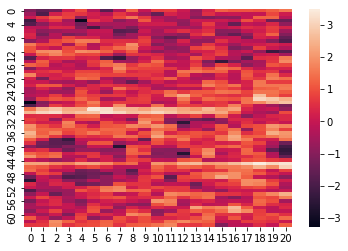

In [92]:
sns.heatmap(X_train[1][5])

In [95]:
np.concatenate(y_train).shape

(232733,)

In [96]:
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(np.concatenate(y_train)),
                                            np.concatenate(y_train))
class_weights = dict(enumerate(weights))
class_name_weights = {np.unique(np.concatenate(y_train))[key]:class_weights[key] for key in class_weights.keys()}
class_name_weights

{'alarm-clock': 2.123088852399197,
 'baby-cry': 1.332880893882904,
 'blender': 2.856986778949436,
 'car-horn': 13.006930084390543,
 'cat-meow': 5.060073053006914,
 'chopping': 3.120247224754652,
 'cooking': 0.6642340557911741,
 'cough': 4.257440775633404,
 'dishwasher': 1.2547335619244786,
 'dog-bark': 0.7516414594051668,
 'door': 2.6321009714886734,
 'doorbell': 6.344091590568352,
 'drill': 1.2015684776267355,
 'engine': 0.31368339048111965,
 'flush': 1.1078514442392278,
 'hair-dryer': 1.3145415007483974,
 'hammer': 0.7489758154054098,
 'hazard-alarm': 0.3492743117930524,
 'knock': 3.6445394468978045,
 'laugh': 2.52208543748239,
 'microwave': 0.938299527893016,
 'phone-ring': 1.1121502026148788,
 'saw': 1.388696290373588,
 'shaver': 1.9144264938141615,
 'snore': 3.010231006027369,
 'toothbrush': 4.160329633006203,
 'typing': 0.479321260351727,
 'vacuum': 0.6073313048334317,
 'water-running': 0.2292019152929961}

In [97]:
ohe = OneHotEncoder()
ohe.fit(np.concatenate(y_train).reshape((-1,1)))

NUM_CLASSES = len(weights)
NUM_FILES = len(y_train)

y_ohe = []
for i in tqdm(range(NUM_FILES)):
    file_ohe = ohe.transform(np.array(y_train[i]).reshape((-1,1))).toarray().reshape((-1, NUM_CLASSES))
    y_ohe.append(file_ohe)              
    X_train[i] = X_train[i].reshape((-1, NUM_BANDS, NUM_FRAMES, 1))
    
y_train = np.array(y_ohe)

100%|██████████| 12224/12224 [00:02<00:00, 5688.36it/s]


In [102]:
X_train[6].shape

(1, 64, 21, 1)

In [105]:
X_test = np.load('temporal_data/{}sec/features_test_{}.npy'.format(sec, sfreq), allow_pickle=True)
y_test = np.load('temporal_data/{}sec/labels_test_{}.npy'.format(sec, sfreq), allow_pickle=True)

X_test = list(X_test)
y_test = list(y_test)
del X_test[speech_index], y_test[speech_index]

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)      

valid_idx = []
for i in range(len(X_test)):
    if len(X_test[i] == 3):
        valid_idx.append(i)
    elif len(X_test[i] != 0):
        print('ghotala! @ {}'.format(i))
    
X_test = X_test[valid_idx]
y_test = y_test[valid_idx]
   
shuffled_idx = np.arange(len(X_test))
np.random.shuffle(shuffled_idx)

X_test = X_test[shuffled_idx]
y_test = y_test[shuffled_idx]

# X_test = np.concatenate(X_test)
# y_test = np.concatenate(y_test)

NUM_TEST_FILES = len(y_test)

y_ohe = []
for i in tqdm(range(NUM_TEST_FILES)):
    file_ohe = ohe.transform(np.array(y_test[i]).reshape((-1,1))).toarray().reshape((-1, NUM_CLASSES))
    y_ohe.append(file_ohe)              
    X_test[i] = X_test[i].reshape((-1, NUM_BANDS, NUM_FRAMES, 1))

y_test = np.array(y_ohe)

100%|██████████| 1176/1176 [00:00<00:00, 5628.49it/s]


In [132]:
X_train.shape

(12224,)

In [130]:
idx = 13
print('X train shape {}'.format(X_train[idx].shape))
print('X test  shape {}'.format(X_test[idx].shape))
print('y train shape {}'.format(y_train[idx].shape))
print('y test  shape {}'.format(y_test[idx].shape))

X train shape (6, 64, 21, 1)
X test  shape (1, 64, 21, 1)
y train shape (6, 29)
y test  shape (1, 29)


In [134]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LSTM, Reshape
from keras.models import Model

# Input
input_shape = (NUM_BANDS, NUM_FRAMES, 1)
batch_input_shape = (1, NUM_BANDS, NUM_FRAMES, 1)
img_input = Input(batch_input_shape = batch_input_shape)

# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1')(img_input)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(x)
x = MaxPooling2D((2, 1), strides=(2, 1), name='pool4')(x)

x = Flatten(name='flatten')(x)

# LSTM
x = Reshape((1, -1))(x)
x = LSTM(units = 256, stateful=True, name='lstm')(x)

# # Block fc
# x = Dense(1024, activation='relu', name='fc1_2')(x)
# x = Dropout(0.4)(x)
x = Dense(128,  activation='relu', name='fc2')(x)
# x = Dropout(0.4)(x)
x = Dense(NUM_CLASSES, activation='sigmoid', name='prediction')(x)
model = Model(img_input, x, name='model')

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(1, 64, 21, 1)]          0         
_________________________________________________________________
conv1 (Conv2D)               (1, 64, 21, 64)           640       
_________________________________________________________________
pool1 (MaxPooling2D)         (1, 32, 10, 64)           0         
_________________________________________________________________
conv2 (Conv2D)               (1, 32, 10, 128)          73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (1, 16, 5, 128)           0         
_________________________________________________________________
conv3_1 (Conv2D)             (1, 16, 5, 256)           295168    
_________________________________________________________________
conv3_2 (Conv2D)             (1, 16, 5, 256)           590080

In [135]:
MODEL_NAME = 'convlstm_{}_{}'.format(sec, sfreq)

BATCH_SIZE = 1

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.load_weights('checkpoints/model_{}.h5'.format(sfreq))

checkpoint = ModelCheckpoint('checkpoints/{}.h5'.format(MODEL_NAME), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1)
reducelr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=1, min_lr=0.000001)

In [36]:
X_train[0][0:1].shape

(1, 64, 11, 1)

In [136]:
history = {
    'train': [],
    'test': []
}

max_acc = 0.0
for epoch in range(10):
    
    # Training
    num_batches = len(X_train) 
    t = trange(num_batches, desc='epoch {}: Train'.format(epoch+1))
    for i in t:
        X_batch = X_train[i]
        y_batch = y_train[i]
        num_samples = len(X_batch)
        for j in range(num_samples):
            X = X_batch[j:j+1]
            y = y_batch[j:j+1]
            metrics = model.train_on_batch(X, y, class_weight=class_weights, reset_metrics=False, return_dict=True)
        lstm = model.get_layer('lstm')
        lstm.reset_states()
        t.set_postfix(metrics)
    history['train'].append(metrics)
    
    # Testing
    num_batches = len(X_test) 
    t = trange(num_batches, desc='epoch {}: Test'.format(epoch+1))
    for i in t:
        X_batch = X_test[i]
        y_batch = y_test[i]
        num_samples = len(X_batch)
        for j in range(num_samples):
            X = X_batch[j:j+1]
            y = y_batch[j:j+1]
            metrics = model.test_on_batch(X, y, reset_metrics=False, return_dict=True)
        lstm = model.get_layer('lstm')
        lstm.reset_states()
        t.set_postfix(metrics)
    history['test'].append(metrics)
    
    if max_acc < metrics['accuracy']:
        print('val accuracy improved from {} to {}. saving model...'.format(max_acc, metrics['accuracy']))
        max_acc = metrics['accuracy']
        model.save('checkpoints/{}.h5'.format(MODEL_NAME))
        
    print('')

epoch 2: Train:   0%|          | 0/12224 [00:00<?, ?it/s]

val accuracy improved from 0.0 to 0.11084204167127609. saving model...



epoch 3: Train:   0%|          | 0/12224 [00:00<?, ?it/s, loss=0.159, accuracy=0.11]

epoch 4: Train:   0%|          | 0/12224 [00:00<?, ?it/s, loss=0.16, accuracy=0.11]

epoch 5: Train:   0%|          | 0/12224 [00:00<?, ?it/s, loss=0.16, accuracy=0.11]

epoch 6: Train:   0%|          | 0/12224 [00:00<?, ?it/s, loss=0.16, accuracy=0.11]

epoch 6: Train:  57%|█████▋    | 6986/12224 [43:17<32:27,  2.69it/s, loss=0.159, accuracy=0.111]  


KeyboardInterrupt: 

In [ ]:
NUM_EPOCHS = 1

for epoch in range(NUM_EPOCHS):
    for file in range(NUM_FILES):
        NUM_FRAMES = X_train[file].shape[0]
        for frame in range(NUM_FRAMES):
        X_file_train = X_train[file][frame:frame+1]
        y_file_train = y_train[file][frame:frame+1]
        history = model.fit(X_file_train, y_file_train, epochs=1, batch_size=1, 
                    class_weight=class_weights, callbacks= [checkpoint, earlystopping, reducelr], shuffle=True)

In [ ]:
plt.plot(history.history['val_accuracy'])

### Contextual Results

In [54]:
model.load_weights('checkpoints/{}.h5'.format(MODEL_NAME))
print('Loaded best checkpoint!')

Loaded best checkpoint!


In [55]:
MODEL_NAME

'convlstm_2_1000'

In [ ]:
labels_test = ohe.inverse_transform(y_test).flatten()

In [ ]:
pred = model.predict(X_test)

In [ ]:
np.unique(labels_test)

In [ ]:
encoding = {label: ohe.transform(np.array(label).reshape(-1,1)).toarray() for label in np.unique(labels_test)}

contexts = {
    'monolithic': ['alarm-clock', 'baby-cry', 'blender', 'car-horn', 'cat-meow',
       'chopping', 'cooking', 'cough', 'dishwasher', 'dog-bark', 'door',
       'doorbell', 'drill', 'engine', 'flush', 'hair-dryer', 'hammer',
       'hazard-alarm', 'knock', 'laugh', 'microwave', 'phone-ring', 'saw',
       'shaver', 'snore', 'speech', 'toothbrush', 'typing', 'vacuum',
       'water-running'],
    'bathroom': ['water-running', 'shaver', 'toothbrush', 'flush', 'hair-dryer'],
    'kitchen': ['hazard-alarm', 'speech', 'chopping', 'water-running', 'microwave', 'blender', 'dishwasher', 'cooking'],
    'bedroom': ['speech', 'baby-cry', 'cough', 'snore', 'alarm-clock'],
    'office': ['phone-ring', 'speech', 'cough', 'door', 'knock', 'typing'],
    'entrance': ['speech', 'door', 'knock', 'doorbell', 'laugh'],
    'workshop': ['drill', 'hazard-alarm', 'speech', 'vacuum', 'hammer', 'saw'],
    'outdoor': ['dog-bark', 'hazard-alarm', 'speech', 'car-horn', 'engine', 'cat-meow']
}

context_encoding = {}
for context in contexts.keys():
    context_encoding[context] = np.zeros((1,30))
    for activity in contexts[context]:
        context_encoding[context] += encoding[activity]    

In [ ]:
for context in contexts.keys():
#     context = list(contexts.keys())[0]
    valid_idx = [i for i, label in enumerate(labels_test) if label in contexts[context]]
    valid_pred = pred[valid_idx]
    valid_labels = labels_test[valid_idx]
    valid_pred = np.argmax(valid_pred * context_encoding[context], axis=1)
    valid_pred = [ohe.categories_[0][pr] for pr in valid_pred]
    acc = accuracy_score(valid_labels, valid_pred)
    f1 = f1_score(valid_labels, valid_pred, average='weighted')
    conf_mat = confusion_matrix(valid_labels, valid_pred, normalize='true')
    label_names = np.unique(valid_labels)
    print('{},{},{},{},{}'.format(sfreq,context,acc,f1,sec))
    # fig, ax = plt.subplots(figsize=(13,10))
    # sns.heatmap(conf_mat, cmap='Blues', ax=ax, xticklabels=label_names, yticklabels=label_names, annot=False)
    # ax.set_title('sFreq: {}, Context: {}, Acc: {}'.format(sfreq,context,acc))
    # ax.set_xlabel('Predicted Label')
    # ax.set_ylabel('True Label')

In [70]:
len(X_train)

12224

### File-Level Metrics 

In [ ]:
num_bands = 64
X_test = np.load('temporal_data/{}sec/features_test_{}.npy'.format(sec, sfreq), allow_pickle=True)
y_test = np.load('temporal_data/{}sec/labels_test_{}.npy'.format(sec, sfreq), allow_pickle=True)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)    

valid_idx = []
for i in range(len(X_test)):
    if len(X_test[i] == 3):
        valid_idx.append(i)
    elif len(X_test[i] != 0):
        print('ghotala! @ {}'.format(i))

X_test = X_test[valid_idx]
y_test = y_test[valid_idx]

X_test = [file.reshape((-1, NUM_BANDS, NUM_FRAMES, 1)) for file in X_test]
y_test = [ohe.transform(np.array(file).reshape(-1,1)).toarray().reshape((-1, NUM_CLASSES)) for file in y_test]

In [ ]:
model.load_weights('checkpoints/{}.h5'.format(MODEL_NAME))
print('Loaded best checkpoint!')

In [ ]:
labels_test = np.array([ohe.inverse_transform(file).flatten() for file in y_test])

In [ ]:
pred = np.array([model.predict(file) for file in X_test])

In [ ]:
pred_time = []
for file in tqdm(X_test):
    for i in range(len(file)):
        frame = file[i:i+1]
        st = time.time()
        prediction = model.predict(frame)
        en = time.time()
        pred_time.append(en-st)

In [ ]:
print('{},{}'.format(sfreq, np.mean(pred_time)))

In [ ]:
encoding = {label: ohe.transform(np.array(label).reshape(-1,1)).toarray() for label in np.unique(np.concatenate(labels_test).flatten())}

contexts = {
    'monolithic': ['alarm-clock', 'baby-cry', 'blender', 'car-horn', 'cat-meow',
       'chopping', 'cooking', 'cough', 'dishwasher', 'dog-bark', 'door',
       'doorbell', 'drill', 'engine', 'flush', 'hair-dryer', 'hammer',
       'hazard-alarm', 'knock', 'laugh', 'microwave', 'phone-ring', 'saw',
       'shaver', 'snore', 'speech', 'toothbrush', 'typing', 'vacuum',
       'water-running'],
    'bathroom': ['water-running', 'shaver', 'toothbrush', 'flush', 'hair-dryer'],
    'kitchen': ['hazard-alarm', 'speech', 'chopping', 'water-running', 'microwave', 'blender', 'dishwasher', 'cooking'],
    'bedroom': ['speech', 'baby-cry', 'cough', 'snore', 'alarm-clock'],
    'office': ['phone-ring', 'speech', 'cough', 'door', 'knock', 'typing'],
    'entrance': ['speech', 'door', 'knock', 'doorbell', 'laugh'],
    'workshop': ['drill', 'hazard-alarm', 'speech', 'vacuum', 'hammer', 'saw'],
    'outdoor': ['dog-bark', 'hazard-alarm', 'speech', 'car-horn', 'engine', 'cat-meow']
}

context_encoding = {}
for context in contexts.keys():
    context_encoding[context] = np.zeros((1,30))
    for activity in contexts[context]:
        context_encoding[context] += encoding[activity]    

In [ ]:
for context in contexts.keys():
    valid_idx = [i for i, label in enumerate(labels_test) if label[0] in contexts[context]]
    valid_pred = pred[valid_idx]
    valid_labels = labels_test[valid_idx]
    valid_pred = [np.argmax(file * context_encoding[context], axis=1) for file in valid_pred]
    # Transform to per file level labels
    valid_pred = [ohe.categories_[0][mode(file)] for file in valid_pred]
    valid_labels = [file[0] for file in valid_labels]
    acc = accuracy_score(valid_labels, valid_pred)
    f1 = f1_score(valid_labels, valid_pred, average='weighted')
    conf_mat = confusion_matrix(valid_labels, valid_pred, normalize='true')
    label_names = np.unique(valid_labels)
    print('{},{},{},{}'.format(sfreq, context, acc, f1))
    fig, ax = plt.subplots(figsize=(13,10))
    sns.heatmap(conf_mat, cmap='Blues', ax=ax, xticklabels=label_names, yticklabels=label_names, annot=False)
    ax.set_title('sFreq: {}, Context: {}, Acc: {}'.format(sfreq,context,acc))
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')